In [11]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [12]:
def com_distance_to_pmf(file, bins):
    ''' Load COM distance as a function of MC steps and calculate potential of mean forece (PMF) '''
    p, r = np.histogram(np.loadtxt(file), bins=bins)
    r = r[1:] / 2 + r[0:-1] / 2
    dr = r[1] - r[0]
    r_max = r[-1]
    gofr = p / p.sum() * r_max / dr # g(r)
    pmf = -np.log(gofr)             # w(r)/kT
    print(f"r_min = {r[0]}, r_max = {r_max} Å, dr = {dr} Å")
    return r, pmf

r_min = 38.334505, r_max = 105.75449499999999 Å, dr = 0.6810100000000006 Å


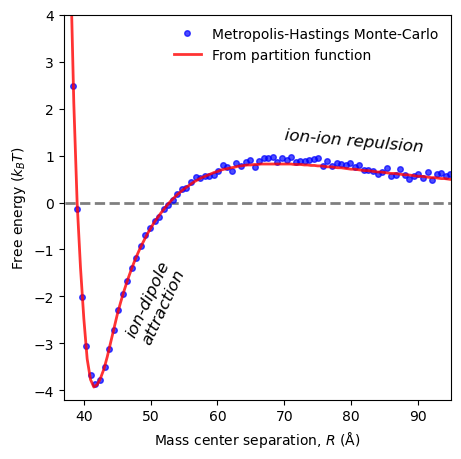

In [35]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 5))
r, pmf = com_distance_to_pmf("com_distance.dat.gz", bins=100)
ax.hlines(0, xmin=r[0]-10, xmax=r[-1]+10, color='k', alpha=0.5, ls='--', lw=2)
ax.plot(r, pmf - 0.7, 'bo', lw=3, label="Metropolis-Hastings Monte-Carlo", alpha=0.7, ms=4)

r, pmf = np.loadtxt("virialize-pmf.dat", usecols=[0,1], unpack=True)
ax.plot(r, pmf, label="From partition function", lw=2, alpha=0.8, color='red')

ax.set_ylabel("Free energy ($k_BT$)")
ax.set_xlabel("Mass center separation, $R$ (Å)")
ax.legend(loc=0, frameon=False)
ax.set_xlim(37, 95)
ax.set_ylim(-4.2, 4)
ax.text(70, 1.1, "ion-ion repulsion", rotation=-5, fontstyle='italic', fontsize='large')
ax.text(46, -3, "ion-dipole\nattraction", rotation=65, fontstyle='italic', fontsize='large')
plt.savefig("twobody.png", bbox_inches="tight", dpi=300)
plt.show()